In [1]:
import numpy as np
from matplotlib import pyplot as plt

#### Параметры задачи

In [43]:
# расчётная область [-L, L]
L = 10
# время расчёта
T = 0.02
# момент времени, графики для которого выведем
time_point = 0.015

# показатель адиабаты
k = 5/3

# начальные условия
v_l, rho_l, P_l = 0, 13, 10 * 1e+5
v_r, rho_r, P_r = 0, 1.3, 1 * 1e+5

# количество узлов пространственной сетки
N = 100
# генерация пространственной сетки
x, h = np.linspace(-L, L, N, retstep = True)

#### Начальные условия

In [3]:
def initial():
    u_init = np.zeros((N, 3))
    for i in range(0, int(N/2)):
        u_init[i] = [rho_l, rho_l*v_l, P_l/(k-1)]

    for i in range(int(N/2), N):
        u_init[i] = [rho_r, rho_r*v_r, P_r/(k-1)]
        
    return u_init

#### Генерация матриц на каждом шаге

In [4]:
def matrix(v: np.ndarray) -> np.ndarray:
    u = v[1]/v[0]
    e = v[2]/v[0]
    c = np.sqrt(k*(k-1)*e)
    
    A = np.array([[0, 1, 0],
                  [-u**2, 2*u, k-1],
                  [-k*u*e, k*e, u]])
    

    Omega = np.array([[-u*c, c, k-1],
                      [-c**2, 0, k-1],
                      [u*c, -c, k-1]])
    
    
    Omega_inv = np.array([[1/(2*c**2),     -2/(2*c**2),     1/(2*c**2)],
                          [(u+c)/(2*c**2), (-2*u)/(2*c**2), (u-c)/(2*c**2)],
                          [1/(2*(k-1)),    0,               1/(2*(k-1))]])
    
    Lambda = np.diag([abs(u+c), abs(u), abs(u-c)])
    
    return A, Omega, Omega_inv, Lambda

#### Поддержание условия на число Куранта:   $\;\;\;CFL_{max} = 0.01$

In [5]:
def New_tau(L, tau):
    l = np.amax(L)
    if tau*l/h <= 0.01:
        return tau
    else:
        return 0.01*h/l

#### Расчёт по схеме Куранта-Изоксона-Риса

In [46]:
def solution():
    sol = [initial()]
    u_curr = initial()
    t = 0
    tau = 1e-3
    
    time = [0]
    while t <= T:
        if t != 0:
            u_curr = u_next
        u_next = np.zeros((N, 3))
        for i in range(1,N-1):
            A, Omega, Omega_inv, Lambda = matrix(u_curr[i])
            pr = np.dot(np.dot(Omega_inv, Lambda), Omega)
            
            tau = New_tau(Lambda, tau)
            
            u_next[i] = u_curr[i] - (tau/(2*h))*np.dot(A, u_curr[i+1] - u_curr[i-1]) + \
            (tau/(2*h))*np.dot(pr, u_curr[i+1] - 2*u_curr[i] + u_curr[i-1])
        
        # граничные условия
        u_next[0] = u_next[1]
        u_next[N-1] = u_next[N-2]
            
        sol = np.concatenate([sol, [u_next]])
        t += tau
        time.append(t)
    return sol, time

sol, time = solution()

#### Получение вектора переменных, которые нас интересуют: $[\rho, u, e]$

In [47]:
def Transform(sol):
    for grid in sol:
        for v in grid:
            v[1] = v[1]/v[0]
            v[2] = v[2]/v[0]/1e3
    return sol

sol = Transform(sol)

#### Графики

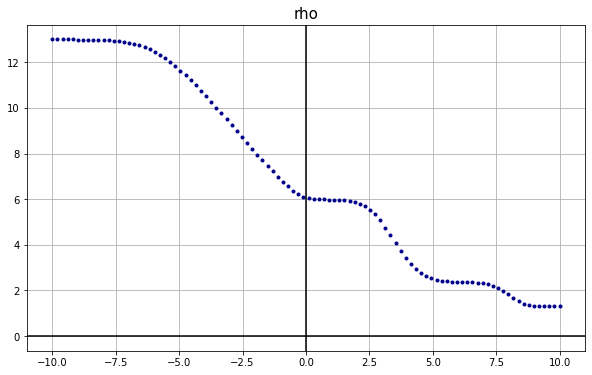

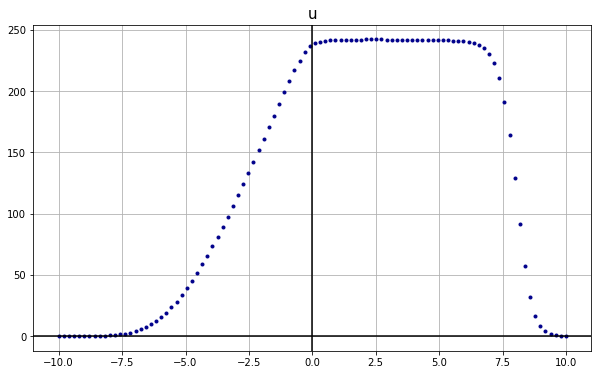

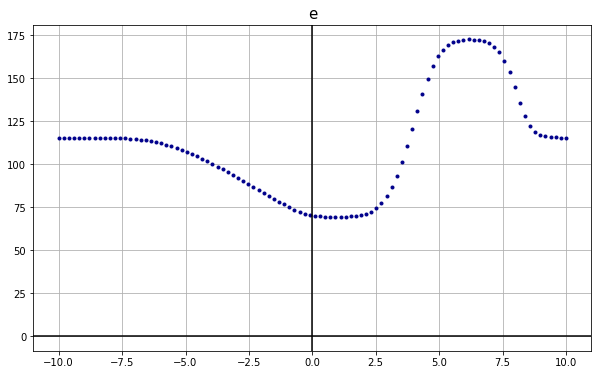

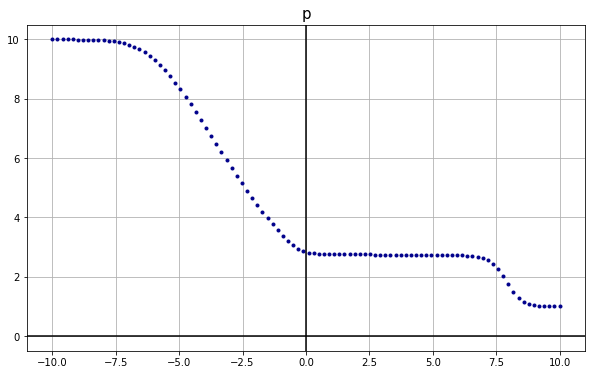

In [53]:
def plot(y, title):
    fig, ax = plt.subplots(figsize = (10, 6))
    plt.plot(x, y, '.', color = 'darkblue')
    plt.title(title, fontsize = 15)
    plt.axvline(x=0, lw=1.5, color='k')
    plt.axhline(y=0, lw=1.5, color='k')
    plt.grid()
    plt.show()
    
time = np.array(time)
p = len(time) -len(time[np.array(time) > time_point])

plot(sol[p][:, 0], 'rho')
plot(sol[p][:, 1], 'u')
plot(sol[p][:, 2], 'e')

# расчёт давления: P = (k-1)*rho*e
pressure = []
for i in range(len(sol[p])):
    pressure.append((k-1) * sol[p][i, 0] * sol[p][i, 2]/1e2)
    
plot(pressure, 'p')